In [ ]:
import numpy as np
import pandas as pd
import scipy.io as sio # for loading MATLAB files
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter, filtfilt, iirnotch, sosfiltfilt, welch

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import os

## Ninapro dataset

In [ ]:
data_DB3_s1_E1 = loadmat("data/DB3/DB3_s1/S1_E1_A1.mat")
print(f"What kind of data structure are we working with? {type(data_DB3_s1_E1)}")
print(f"What are the keys of the data structure? \n{[key for key in data_DB3_s1_E1.keys()]}")

In [ ]:
emg = data_DB3_s1_E1["emg"]
print("EMG data dimension: {}".format(emg.shape))
print("EMG data type: {}".format(type(emg)))

In [ ]:
## !! stimulus -> restimulus !!
emg_rectified = data_DB3_s1_E1["emg"].copy()

#Stimulus is the type of movement that is being performed
stimulus = data_DB3_s1_E1["stimulus"] 
#Repetition is the number of times the movement has been repeated
repetition = data_DB3_s1_E1["repetition"] 

#Restimulus and rerepetition are the stimulus and repetition that have been processed for better correspondance to real movement
restimulus = data_DB3_s1_E1['restimulus']
rerepetition = data_DB3_s1_E1['rerepetition']

print(f'What are the shape of the data that we are working with? \nEMG: {emg_rectified.shape}, \nStimulus {stimulus.shape}, \nRepetition {repetition.shape}, \nRestimulus {restimulus.shape}, \nRerepetition {rerepetition.shape}')

# -1 because 0 is the resting condition
n_stimuli = len(np.unique(restimulus)) - 1 
# -1 because 0 is not a repetition
n_repetitions = len(np.unique(rerepetition)) - 1 
n_channels = emg_rectified.shape[1]

print(f'How many types of movement are there? {n_stimuli}') 
print(np.unique(restimulus))
print(f'How many repetitions are there? {n_repetitions}') 

number_of_samples_per_trial = np.zeros((n_stimuli+1, n_repetitions))

for stimuli_idx in range(n_stimuli+1): # include the resting condition
    for repetition_idx in range(n_repetitions):
        
        idx = np.logical_and(restimulus == stimuli_idx, rerepetition == repetition_idx+1)
        number_of_samples_per_trial[stimuli_idx, repetition_idx] = np.sum(idx.astype(int))

print("Nb of samples for each trial")
number_of_samples_per_trial

In [ ]:
#defining the length of the moving average window
mov_mean_length = 50
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

#initializing the data structure
emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli+1)]
emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli+1)]

# time dependant windowing

# Assuming the trial duration varies
trial_duration = 8  # movement lasts for 5 sec + rest 3 sec
# Define the sampling rate
sampling_rate = 2000  # Hz (samples per second)

# Calculate the window size based on time
window_size = trial_duration * sampling_rate  # Convert duration to number of samples
window_size = 1000

# Now apply the windowing process based on this dynamically computed window_size
for stimuli_idx in range(n_stimuli+1):
    for repetition_idx in range(n_repetitions):
        idx = np.logical_and(restimulus == stimuli_idx, rerepetition == repetition_idx + 1).flatten()
        emg_windows[stimuli_idx][repetition_idx] = emg_rectified[idx, :]
        
        # Adjust the window size dynamically (depends on the duration of the trial)
        # window_weights = np.ones(window_size) / window_size  # Moving average weights
        # emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], window_weights, axis=0)

np.shape(emg_windows[0][0])


In [ ]:
# Channel 1-8 : equally spaced electrodes on the forearm
# Channel 9-10 : Flexor Digitorum Superficialis and Extensor Digitorum Superficialis muscles
# Channel 11-12 : Biceps Brachii and Triceps Brachii muscles

# Plot signal for rest (0)
for rep in range(n_repetitions):
    plt.figure(figsize=(12, 6))
    plt.title(f"Resting condition (0), repetition {rep+1}")
    for channel_idx in range(n_channels): 
        plt.subplot(3, 4, channel_idx+1)
        plt.plot(emg_windows[0][rep][:, channel_idx])
        plt.title(f"Channel {channel_idx+1}")
    plt.tight_layout()
    plt.show()

# fig, ax = plt.subplots(3, 4, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
# ax = ax.ravel()

# #10 EMG channels
# number_of_emg_channels = emg_rectified.shape[-1]
# # plot Rectified EMG signal
# for channel_idx in range(number_of_emg_channels): 
#     ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
#     ax[channel_idx].set_title(f"Channel {channel_idx+1}")
# plt.suptitle("Rectified EMG signal for restimulus 1")

In [ ]:
# Plot signal for fist action (6)


for rep in range(n_repetitions):
    fig, ax = plt.subplots(3, 4, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
    ax = ax.ravel()

    #10 EMG channels
    number_of_emg_channels = emg_rectified.shape[-1]
    # plot Rectified EMG signal
    for channel_idx in range(number_of_emg_channels): 
        ax[channel_idx].plot(emg_windows[6][rep][:, channel_idx])
        ax[channel_idx].set_title(f"Channel {channel_idx+1}")
    plt.suptitle(f"Rectified EMG signal for restimulus 1 and repetition {rep+1}")

# fig, ax = plt.subplots(3, 4, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
# ax = ax.ravel()

# #10 EMG channels
# number_of_emg_channels = emg_rectified.shape[-1]
# # plot Rectified EMG signal
# for channel_idx in range(number_of_emg_channels): 
#     ax[channel_idx].plot(emg_windows[6][0][:, channel_idx])
#     ax[channel_idx].set_title(f"Channel {channel_idx+1}")
# plt.suptitle("Rectified EMG signal for restimulus 1")


# # Envelopes
# fig, ax = plt.subplots(3, 4, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
# ax = ax.ravel()

# #10 EMG channels
# number_of_emg_channels = emg_rectified.shape[-1]
# # plot Rectified EMG signal
# for channel_idx in range(number_of_emg_channels): 
#     ax[channel_idx].plot(emg_envelopes[6][0][:, channel_idx])
#     ax[channel_idx].set_title(f"Channel {channel_idx+1}")
# plt.suptitle("Rectified EMG signal for restimulus 1")

In [ ]:
# Plot signal for wrist flexion action (13)
for rep in range(n_repetitions):
    fig, ax = plt.subplots(3, 4, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
    ax = ax.ravel()

    #10 EMG channels
    number_of_emg_channels = emg_rectified.shape[-1]
    # plot Rectified EMG signal
    for channel_idx in range(number_of_emg_channels): 
        ax[channel_idx].plot(emg_windows[13][rep][:, channel_idx])
        ax[channel_idx].set_title(f"Channel {channel_idx+1}")
    plt.suptitle(f"Rectified EMG signal for restimulus 1 and repetition {rep+1}")

# fig, ax = plt.subplots(3, 4, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
# ax = ax.ravel()

# #10 EMG channels
# number_of_emg_channels = emg_rectified.shape[-1]
# # plot Rectified EMG signal
# for channel_idx in range(number_of_emg_channels): 
#     ax[channel_idx].plot(emg_windows[13][0][:, channel_idx])
#     ax[channel_idx].set_title(f"Channel {channel_idx+1}")
# plt.suptitle("Rectified EMG signal for restimulus 1")

In [ ]:
# Plot signal for wrist extension action (14)
for rep in range(n_repetitions):
    fig, ax = plt.subplots(3, 4, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
    ax = ax.ravel()

    #10 EMG channels
    number_of_emg_channels = emg_rectified.shape[-1]
    # plot Rectified EMG signal
    for channel_idx in range(number_of_emg_channels): 
        ax[channel_idx].plot(emg_windows[14][rep][:, channel_idx])
        ax[channel_idx].set_title(f"Channel {channel_idx+1}")
    plt.suptitle(f"Rectified EMG signal for restimulus 1 and repetition {rep+1}")

# fig, ax = plt.subplots(3, 4, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
# ax = ax.ravel()

# #10 EMG channels
# number_of_emg_channels = emg_rectified.shape[-1]
# # plot Rectified EMG signal
# for channel_idx in range(number_of_emg_channels): 
#     ax[channel_idx].plot(emg_windows[14][0][:, channel_idx])
#     ax[channel_idx].set_title(f"Channel {channel_idx+1}")
# plt.suptitle("Rectified EMG signal for restimulus 1")

In [ ]:
# emg_average_activations = np.zeros((n_channels, n_stimuli+1, n_repetitions))
# for stimuli_idx in range(n_stimuli+1):
#     for repetition_idx in range(n_repetitions):
#         #mean across time for each channel
#         emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(emg_envelopes[stimuli_idx][repetition_idx], axis=0) 

# vmin = np.min(emg_average_activations) 
# vmax = np.max(emg_average_activations)

# fig, ax = plt.subplots(9, 2, figsize=(10, 30), constrained_layout=True, sharex=True, sharey=True)
# ax = ax.ravel()

# for stimuli_idx in range(n_stimuli+1):
#     sns.heatmap(np.squeeze(emg_average_activations[:, stimuli_idx, :]), ax=ax[stimuli_idx] ,xticklabels=False, yticklabels=False, cbar=True, vmin=vmin, vmax=vmax,)
#     ax[stimuli_idx].title.set_text("Restimulus " + str(stimuli_idx))
#     ax[stimuli_idx].set_xlabel("Rerepetition")
#     ax[stimuli_idx].set_ylabel("EMG channel")

## Personal data

In [ ]:
data_pers = pd.read_csv("data/pers_data/cleaned/cleaned_WS_R_4_250328161002.csv")
print(f"Data shape: {data_pers.shape}")
print(f"Data columns: {data_pers.columns}")

In [ ]:
# Look for the first window of fist action
start_id = data_pers[(data_pers["Action1"] == "Rest") & (data_pers["Action2"] == "Fist")].index[0]
end_id = data_pers[(data_pers["Action1"] == "Fist") & (data_pers["Action2"] == "Rest")].index[-1]
window_df = data_pers.loc[start_id:end_id]

# plt.figure(figsize=(12, 4))
# plt.plot(window_df['Timestamp'], window_df['Channel1'], label='Channel1')
# plt.plot(window_df['Timestamp'], window_df['Channel2'], label='Channel2')
# plt.title("First 'Fist' Action Window")
# plt.xlabel("Time (s)")
# plt.ylabel("Signal")
# plt.legend()
# plt.grid()
# plt.tight_layout()
# plt.show()

fig, ax = plt.subplots(2, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

#2 EMG channels
for channel_idx in range(2): 
    ax[channel_idx].plot(window_df['Timestamp'], window_df['Channel{}'.format(channel_idx+1)])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal for restimulus 1")


In [ ]:
# Same for wrist flexion action
start_id = data_pers[(data_pers["Action1"] == "Rest") & (data_pers["Action2"] == "WristFlexion")].index[0]
end_id = data_pers[(data_pers["Action1"] == "WristFlexion") & (data_pers["Action2"] == "Rest")].index[-1]
window_df = data_pers.loc[start_id:end_id]

fig, ax = plt.subplots(2, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

#2 EMG channels
for channel_idx in range(2): 
    ax[channel_idx].plot(window_df['Timestamp'], window_df['Channel{}'.format(channel_idx+1)])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal for restimulus 1")


In [ ]:
# Same for wrist extension action
start_id = data_pers[(data_pers["Action1"] == "Rest") & (data_pers["Action2"] == "WristExt")].index[0]
end_id = data_pers[(data_pers["Action1"] == "WristExt") & (data_pers["Action2"] == "Rest")].index[-1]
window_df = data_pers.loc[start_id:end_id]

fig, ax = plt.subplots(2, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

#2 EMG channels
for channel_idx in range(2): 
    ax[channel_idx].plot(window_df['Timestamp'], window_df['Channel{}'.format(channel_idx+1)])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal for restimulus 1")

# Correlation of channels between dataset

In [ ]:
def compute_flat_label(row):
    if row['Action1'] == 'Rest' and pd.isna(row['Action2']): # return 'Rest' if Action1 is 'Rest' and Action2 is NaN
        return 'Rest'
    elif row['Action1'] != 'Rest' and pd.isna(row['Action2']): # if Action2 is NaN, return Action1 (except for 'Rest')
        return row['Action1']
    else:
        return row['Action2']  # transition phase, but will be merged into gesture


In [ ]:
# Create single label for each row
data_pers_copy = data_pers.copy()
data_pers_copy.drop(index=0, inplace=True)
data_pers_copy['Gesture'] = data_pers_copy.apply(compute_flat_label, axis=1)
data_pers_copy.drop(columns=['Action1', 'Action2'], inplace=True)

In [ ]:
data_pers_copy.head()

## Resample Ninapro and personnal data at 1000Hz

In [ ]:
from scipy.signal import resample
from scipy.stats import mode

def downsample_dataframe_with_labels(df, target_freq, time_col='Timestamp', label_cols=None, method='resample'):
    """
    Downsamples a DataFrame with timestamp, signal columns, and optional label columns.
    
    Parameters:
        df : pd.DataFrame
            Input data (must include a time column).
        target_freq : int
            Target sampling frequency in Hz.
        time_col : str
            Name of the time column.
        label_cols : list of str
            Columns with categorical labels (e.g., ['FlatLabel', 'Action1', 'Action2']).
        method : str
            'resample' (FFT-based) or 'average' (bin-average + mode for labels).
    
    Returns:
        pd.DataFrame
            Downsampled DataFrame with aligned time, signal, and label columns.
    """
    if time_col not in df.columns:
        raise ValueError(f"{time_col} must be in dataframe")

    label_cols = label_cols or []
    all_cols = df.columns.tolist()
    signal_cols = [col for col in all_cols if col not in [time_col] + label_cols]

    t_orig = df[time_col].values
    t_start, t_end = t_orig[0], t_orig[-1]
    duration = t_end - t_start
    n_target = int(duration * target_freq)

    # Downsample signals
    if method == 'resample':
        signals_ds = pd.DataFrame(
            resample(df[signal_cols].values, n_target),
            columns=signal_cols
        )
    elif method == 'average':
        df_indexed = df.set_index(time_col)
        df_indexed.index = pd.to_datetime(df_indexed.index, unit='s')
        signals_ds = df_indexed[signal_cols].resample(f"{int(1000/target_freq)}ms").mean().dropna().reset_index(drop=True)
    else:
        raise ValueError("method must be 'resample' or 'average'")

    # Generate new time vector
    t_uniform = np.linspace(t_start, t_end, n_target, endpoint=False)
    signals_ds.insert(0, time_col, t_uniform)

    # Downsample labels using mode per time bin
    if label_cols:
        df_label = df[[time_col] + label_cols].copy()
        df_label.index = pd.to_datetime(df_label[time_col], unit='s')

        bin_size_ms = int(1000 / target_freq)
        label_resampled = []

        for col in label_cols:
            grouped = df_label[col].resample(f"{bin_size_ms}ms").agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
            label_resampled.append(grouped)

        label_df = pd.concat(label_resampled, axis=1)
        label_df.columns = label_cols
        label_df = label_df.dropna().reset_index(drop=True)

        # Align label_df to signal df
        label_df = label_df.iloc[:len(signals_ds)]
        signals_ds[label_cols] = label_df

    return signals_ds


In [ ]:
downsampled_data_pers = downsample_dataframe_with_labels(data_pers_copy, target_freq=1000, time_col='Timestamp', label_cols=['Gesture'], method='resample')
downsampled_data_pers.head()

In [ ]:
np.shape(data_DB3_s1_E1['emg'])

In [ ]:
# Create an empty DataFrame to store the data
data_ninapro = pd.DataFrame()

for channel in range(n_channels):
    data_ninapro[f'Channel{channel+1}'] = emg_rectified[:, channel].flatten()
data_ninapro['Stimulus'] = stimulus.flatten()
data_ninapro['Repetition'] = repetition.flatten()
data_ninapro['Restimulus'] = restimulus.flatten()
data_ninapro['Rerepetition'] = rerepetition.flatten()

sampling_rate = 2000  # Hz (samples per second)
n_samples = data_ninapro.shape[0]
data_ninapro['Timestamp'] = np.arange(n_samples) / sampling_rate  # Create a timestamp column


In [ ]:
data_ninapro.head()

In [ ]:
data_ninapro_copy = data_ninapro.copy()
downsampled_data_ninapro = downsample_dataframe_with_labels(data_ninapro_copy, target_freq=1000, time_col='Timestamp', label_cols=['Stimulus', 'Repetition', 'Restimulus', 'Rerepetition'], method='resample')
downsampled_data_ninapro.head()

In [ ]:
downsampled_data_ninapro.to_csv("data/DB3/downsampled/downsampled_S1_E1_A1.csv", index=False)

In [ ]:
downsampled_data_ninapro = pd.read_csv("data/DB3/downsampled/downsampled_S1_E1_A1.csv")
downsampled_data_ninapro.head()

In [ ]:
downsampled_data_ninapro.Stimulus.unique()
downsampled_data_ninapro.Restimulus.unique()

stim_1 = downsampled_data_ninapro[downsampled_data_ninapro['Stimulus'] == 1]["Channel1"]
restim_1 = downsampled_data_ninapro[downsampled_data_ninapro['Restimulus'] == 1]["Channel1"]
rep_1 = downsampled_data_ninapro[downsampled_data_ninapro['Repetition'] == 1]["Channel1"]
rerep_1 = downsampled_data_ninapro[downsampled_data_ninapro['Rerepetition'] == 1]["Channel1"]


# plot stim_1 and restim_1
plt.figure(figsize=(12, 6))
plt.plot(restim_1, label='Restimulus 1')
plt.plot(stim_1, label='Stimulus 1')
# plt.plot(rep_1, label='Repetition 1')
# plt.plot(rerep_1, label='Rerepetition 1')
plt.title("Stimulus 1 vs Restimulus 1")
plt.xlabel("Samples")
plt.ylabel("Signal")
plt.legend()


stim_1_r1 = downsampled_data_ninapro.query("Stimulus == 1 and Repetition == 1")["Channel1"]
stim_1_r2 = downsampled_data_ninapro.query("Stimulus == 1 and Repetition == 2")["Channel1"]
stim_1_r3 = downsampled_data_ninapro.query("Stimulus == 1 and Repetition == 3")["Channel1"]
stim_1_r4 = downsampled_data_ninapro.query("Stimulus == 1 and Repetition == 4")["Channel1"]

print("length of stimulus 1 for repetition 1,2,3,4:", len(stim_1_r1), len(stim_1_r2), len(stim_1_r3), len(stim_1_r4))

restim_1_r1 = downsampled_data_ninapro.query("Restimulus == 1 and Rerepetition == 1")["Channel1"]
restim_1_r2 = downsampled_data_ninapro.query("Restimulus == 1 and Rerepetition == 2")["Channel1"]
restim_1_r3 = downsampled_data_ninapro.query("Restimulus == 1 and Rerepetition == 3")["Channel1"]
restim_1_r4 = downsampled_data_ninapro.query("Restimulus == 1 and Rerepetition == 4")["Channel1"]

print("length of restimulus 1 for repetition 1,2,3,4:",len(restim_1_r1), len(restim_1_r2), len(restim_1_r3), len(restim_1_r4))


## Correlation between channels

In [ ]:
# Map personnal labels to Ninapro labels

movement_ExA = {
    0: "Rest",
    1: "IndexFlex",
    3: "MiddleFlex",
    5: "RingPinkyFlex",
    7: "RingPinkyFlex",
    9: "ThumbAdd",
    10: "ThumbAbd",
    11: "ThumbFlex",
}

movement_ExB = {
    0: "Rest",
    1: "ThumbUp",
    2: "Scisors",
    5: "Palm",
    6: "Fist",
    9: "WristRotIn",
    10: "WristRotExt",
    13: "WristFlexion",
    14: "WristExt",
}

movement_ExC = {
    0: "Rest",
    1: "CylindGraspClosed",
    2: "CylindGraspClosed",
    3: "HookGraspClosed",
    14: "PinchGraspClosed",
    15: "PinchGraspClosed",
    19: "LumbGraspClosed",
}

pers_gestures = {"Rest", "Fist", "WristFlexion", "WristExt", "WristRotIn", "WristRotExt", "Palm"}

gesture_to_id = {v: k for k, v in movement_ExB.items() if v in pers_gestures}
gesture_to_id

In [ ]:
# Channel 1 pers data -> Channel 2 ninapro
# Channel 2 pers data -> Channel 8 ninapro

# --> train classifier on Ninapro data (2 & 8) and test on personal data (1 & 2)

## Model

In [ ]:
def build_dataset_from_ninapro(emg, stimulus, repetition, features=None):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    # Total number of samples is the product of stimuli and repetitions
    n_samples = n_stimuli * n_repetitions
    
    # Number of channels in the EMG data
    n_channels = emg.shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(n_channels for feature in features)
    
    print(f"Number of samples: {n_samples}, Number of features: {n_features}, Number of channels: {n_channels}")
    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0
    
    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            # Assign the label for the current sample
            labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0

            # Select the time steps corresponding to the current stimulus and repetition
            
            selected_tsteps = np.logical_and(stimulus == stimulus.unique()[i], repetition == repetition.unique()[j]).squeeze()

            # Loop over each feature function provided
            for feature in features:
                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                # Apply the feature function to the selected EMG data and store the result

                dataset[current_sample_index, selected_features] = feature(emg[selected_tsteps, :])
                # Update the feature index for the next feature
                current_feature_index += n_channels

            # Move to the next sample
            current_sample_index += 1
            
    # Return the constructed dataset and corresponding labels
    return dataset, labels

In [ ]:
# Define the features 

# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)
# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0)
# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)
# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))
# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)
# Slope sign changes (SSC)
ssc = lambda x: np.sum((np.diff(x, axis=0)[:-1, :] * np.diff(x, axis=0)[1:, :]) < 0, axis=0)

#Feel free to add more features, e.g. frequency domain features. (See https://doi.org/10.3390/s19204596 and https://doi.org/10.1088/0967-3334/24/2/307)

features_selected = [mav, std, maxav, rms, wl, ssc]

In [ ]:
# From array to dataframe
data = loadmat("data/DB3/DB3_s1/S1_E1_A1.mat")
# data = pd.read_csv("data/DB3/downsampled/downsampled_S1_E1_A1.csv")
sampling_rate=2000 # Hz (samples per second)

data_ninapro_df = pd.DataFrame(data_ninapro, columns=[f'Channel{i+1}' for i in range(n_channels)] + ['Stimulus', 'Repetition', 'Restimulus', 'Rerepetition'])
for channel in range(n_channels):
    data_ninapro_df[f'Channel{channel+1}'] = data['emg'][:, channel].flatten()
data_ninapro_df['Stimulus'] = data["stimulus"]
data_ninapro_df['Repetition'] = data["repetition"]
data_ninapro_df['Restimulus'] = data["restimulus"]
data_ninapro_df['Rerepetition'] = data["rerepetition"]
data_ninapro_df['Timestamp'] = np.arange(data_ninapro_df.shape[0]) / sampling_rate  # Create a timestamp column

data_ninapro_df.head() # warning this is not the downsampled dataset (take the one from next cell)

In [ ]:
data = pd.read_csv("data/DB3/downsampled/downsampled_S1_E1_A1.csv")
data.head()

In [ ]:
data_ninapro_df.head()

In [ ]:
# Keep selected Channels
training_data = data_ninapro_df.drop(columns=['Channel1', 'Channel3', 'Channel4', 'Channel5', 'Channel6', 'Channel7', 'Channel9', 'Channel10', 'Channel11', 'Channel12'])

# Keep selected Stimuli (from gesture_to_id)
training_data = training_data[training_data['Restimulus'].isin(gesture_to_id.values())]

# Map the gesture labels to their corresponding IDs
print(training_data['Restimulus'].unique())
for key, value in gesture_to_id.items():
    if value in training_data['Restimulus'].values:
        # training_data.loc[training_data['Stimulus'] == value, 'Stimulus'] = key
        print(key)

training_data.sample(5)

In [ ]:
# Count how many stimuls!=restimulus
print(training_data[training_data['Stimulus']!=training_data['Restimulus']].shape[0])
print(training_data.shape[0])


In [ ]:
stimulus.unique()


In [ ]:
# Take only selected mouvements and channels 2 & 8 for Ninapro data

# create empty dataframe to store the data
# emg_training = pd.DataFrame()
# for key, value in gesture_to_id.items():
#     mvmt = value
#     emg_training = pd.concat([emg_training, emg_windows[mvmt][:][:, [1, 7]]], axis=0)

# emg_windows[13][rep][:, channel_idx]
# emg_training = emg_rectified[:, [1, 7]] # Channel 2 and 8 (0-indexed)

emg_training = training_data[['Channel2', 'Channel8']].values
stimulus = training_data['Restimulus']
repetition = training_data['Rerepetition']
dataset, labels = build_dataset_from_ninapro(
    emg=emg_training,
    stimulus=stimulus,
    repetition=repetition,
    features= features_selected
)

print(f"dataset dimension: {dataset.shape}")
print(f"labels dimension: {labels.shape}")

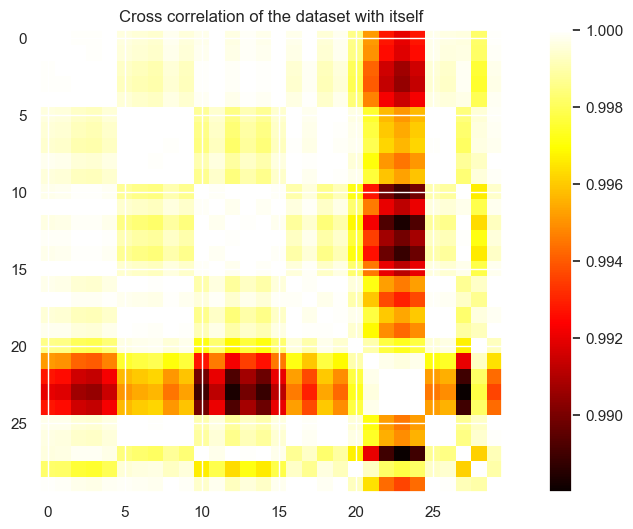

In [158]:
# plot the cross correlation of the dataset with itself

plt.figure(figsize=(12, 6))
plt.title("Cross correlation of the dataset with itself")
plt.imshow(np.corrcoef(dataset), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

# normal that every 5 labels are the same, so it's a good sanity check
